In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
# TODO: 改成你自己的真实路径
disc_pt_path = "/mnt/liangjm/SpRR_data/disc_maps/TCGA-38-4629-01Z-00-DX1/patch_000000.pt"

assert os.path.isfile(disc_pt_path), f"File not found: {disc_pt_path}"
print("Using disc_map:", disc_pt_path)


Using disc_map: /mnt/liangjm/SpRR_data/disc_maps/TCGA-38-4629-01Z-00-DX1/patch_000000.pt


In [3]:
D = torch.load(disc_pt_path, map_location="cpu")

print("Type:", type(D))
print("Shape:", D.shape if torch.is_tensor(D) else None)
print("Dtype:", D.dtype if torch.is_tensor(D) else None)

# 期望: [1, 512, 512]


Type: <class 'torch.Tensor'>
Shape: torch.Size([1, 512, 512])
Dtype: torch.float32


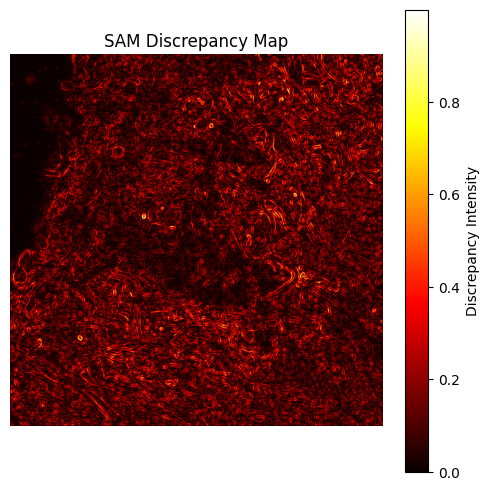

Stats: min = 0.0 max = 0.99999905 mean = 0.0994585


In [4]:
# squeeze to [H, W]
D_img = D.squeeze(0).clamp(0, 1).numpy()

plt.figure(figsize=(6, 6))
plt.imshow(D_img, cmap="hot")
plt.colorbar(label="Discrepancy Intensity")
plt.title("SAM Discrepancy Map")
plt.axis("off")
plt.show()

print("Stats:",
      "min =", D_img.min(),
      "max =", D_img.max(),
      "mean =", D_img.mean())


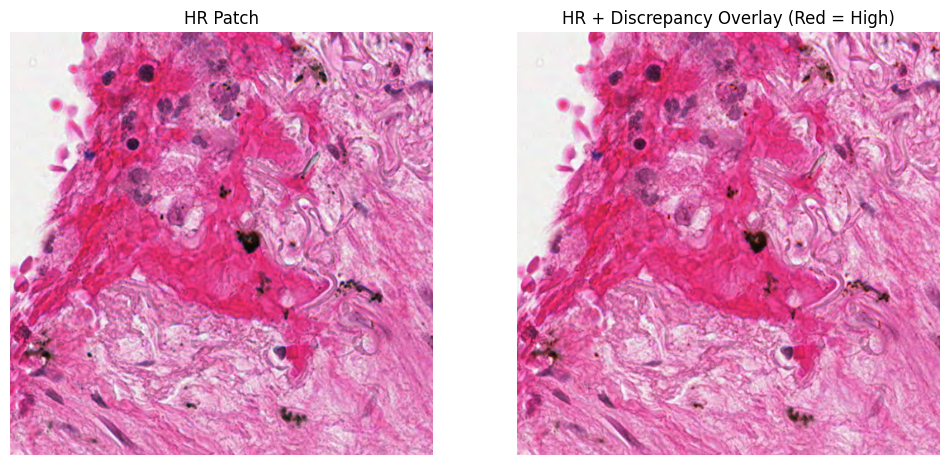

In [5]:
# 推断 HR patch 路径（和你的 loader 逻辑一致）
meta_slide = os.path.basename(os.path.dirname(disc_pt_path))
patch_name = os.path.basename(disc_pt_path).replace(".pt", ".png")

hr_img_path = f"/mnt/liangjm/SpRR_data/hr_png/{meta_slide}/{patch_name}"

assert os.path.isfile(hr_img_path), f"HR image not found: {hr_img_path}"

hr_img = Image.open(hr_img_path).convert("RGB")
hr_np = np.array(hr_img)

# 归一化 disc_map 到 [0,1]
heat = D_img
heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-6)

# 用红色通道叠加
overlay = hr_np.copy().astype(np.float32)
overlay[..., 0] = np.clip(overlay[..., 0] * (1 - heat) + 255 * heat, 0, 255)

overlay = overlay.astype(np.uint8)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(hr_np)
plt.title("HR Patch")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("HR + Discrepancy Overlay (Red = High)")
plt.axis("off")

plt.show()
